In [ ]:
# Cell 1: Install dependencies
!pip install -q tensorflow tensorflowjs matplotlib opencv-python pillow scikit-learn numpy pandas

# Cell 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Cell 3: Import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
import shutil
from glob import glob
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 4: Configuration
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001

CLASSES = [
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___healthy'
]

SIMPLE_NAMES = {
    'Tomato___Bacterial_spot': 'Bacterial Spot',
    'Tomato___Early_blight': 'Early Blight',
    'Tomato___Late_blight': 'Late Blight',
    'Tomato___Leaf_Mold': 'Leaf Mold',
    'Tomato___healthy': 'Healthy'
}

# Cell 5: Load and preprocess dataset properly
def load_and_preprocess_dataset(base_path='/content/drive/MyDrive/PlantVillage', limit_per_class=500):
    images = []
    labels = []

    CLASS_INDICES = {class_name: idx for idx, class_name in enumerate(CLASSES)}

    print("🔍 Looking for classes...")

    for class_name in CLASSES:
        class_path = os.path.join(base_path, class_name)

        if not os.path.exists(class_path):
            print(f"⚠️  {class_name} not found at {class_path}")
            # Try alternative naming
            alt_paths = [
                os.path.join(base_path, class_name.replace('___', ' ')),
                os.path.join(base_path, class_name.replace('___', '_')),
            ]
            for alt_path in alt_paths:
                if os.path.exists(alt_path):
                    class_path = alt_path
                    print(f"   Found at alternative: {alt_path}")
                    break

        if not os.path.exists(class_path):
            print(f"❌ Could not find {class_name}")
            continue

        print(f"📂 Loading {class_name}...")

        # Get image files
        image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
            image_files.extend(glob(os.path.join(class_path, ext)))

        print(f"   Found {len(image_files)} images")

        # Limit and shuffle
        np.random.shuffle(image_files)
        image_files = image_files[:min(limit_per_class, len(image_files))]

        # Load images
        loaded = 0
        for img_path in tqdm(image_files, desc=f"  Processing {class_name}"):
            try:
                # Load with PIL for better handling
                img = Image.open(img_path)
                img = img.convert('RGB')

                # Resize
                img = img.resize((IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS)
                img_array = np.array(img)

                # Check if image is valid
                if img_array.shape != (IMG_SIZE, IMG_SIZE, 3):
                    continue

                # Normalize
                img_array = img_array.astype(np.float32) / 255.0

                images.append(img_array)
                labels.append(CLASS_INDICES[class_name])
                loaded += 1

            except Exception as e:
                continue

        print(f"   ✅ Loaded {loaded} images")

    if len(images) == 0:
        print("❌ No images loaded!")
        return None, None

    images = np.array(images)
    labels = np.array(labels)

    print(f"\n✅ Dataset loaded: {len(images)} images")

    # Show class distribution
    unique, counts = np.unique(labels, return_counts=True)
    print("\n📊 Class distribution:")
    for idx, count in zip(unique, counts):
        print(f"   {SIMPLE_NAMES[CLASSES[idx]]}: {count} images")

    return images, labels

# Load dataset
print("🚀 Loading dataset from Google Drive...")
X, y = load_and_preprocess_dataset(limit_per_class=500)

if X is None:
    # Try alternative path
    print("\n🔄 Trying alternative path...")
    X, y = load_and_preprocess_dataset(base_path='/content/drive/MyDrive', limit_per_class=500)


🚀 Loading dataset from Google Drive...
🔍 Looking for classes...
⚠️  Tomato___Bacterial_spot not found at /content/drive/MyDrive/PlantVillage/Tomato___Bacterial_spot
   Found at alternative: /content/drive/MyDrive/PlantVillage/Tomato_Bacterial_spot
📂 Loading Tomato___Bacterial_spot...
   Found 2127 images


  Processing Tomato___Bacterial_spot: 100%|██████████| 500/500 [00:51<00:00,  9.65it/s] 


   ✅ Loaded 500 images
⚠️  Tomato___Early_blight not found at /content/drive/MyDrive/PlantVillage/Tomato___Early_blight
   Found at alternative: /content/drive/MyDrive/PlantVillage/Tomato_Early_blight
📂 Loading Tomato___Early_blight...
   Found 1000 images


  Processing Tomato___Early_blight: 100%|██████████| 500/500 [00:43<00:00, 11.48it/s] 


   ✅ Loaded 500 images
⚠️  Tomato___Late_blight not found at /content/drive/MyDrive/PlantVillage/Tomato___Late_blight
   Found at alternative: /content/drive/MyDrive/PlantVillage/Tomato_Late_blight
📂 Loading Tomato___Late_blight...
   Found 1925 images


  Processing Tomato___Late_blight: 100%|██████████| 500/500 [00:23<00:00, 21.29it/s]


   ✅ Loaded 500 images
⚠️  Tomato___Leaf_Mold not found at /content/drive/MyDrive/PlantVillage/Tomato___Leaf_Mold
   Found at alternative: /content/drive/MyDrive/PlantVillage/Tomato_Leaf_Mold
📂 Loading Tomato___Leaf_Mold...
   Found 962 images


  Processing Tomato___Leaf_Mold: 100%|██████████| 500/500 [00:19<00:00, 25.92it/s] 


   ✅ Loaded 500 images
⚠️  Tomato___healthy not found at /content/drive/MyDrive/PlantVillage/Tomato___healthy
   Found at alternative: /content/drive/MyDrive/PlantVillage/Tomato_healthy
📂 Loading Tomato___healthy...
   Found 1591 images


  Processing Tomato___healthy: 100%|██████████| 500/500 [00:31<00:00, 15.90it/s] 


   ✅ Loaded 500 images

✅ Dataset loaded: 2500 images

📊 Class distribution:
   Bacterial Spot: 500 images
   Early Blight: 500 images
   Late Blight: 500 images
   Leaf Mold: 500 images
   Healthy: 500 images


In [ ]:
# Cell 6: Data preprocessing and augmentation
print("\n🔄 Preprocessing data...")

if X is not None:
    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"📈 Data split:")
    print(f"   Training: {X_train.shape[0]} images")
    print(f"   Validation: {X_val.shape[0]} images")
    print(f"   Test: {X_test.shape[0]} images")

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.7, 1.3],
        channel_shift_range=0.2,
        fill_mode='nearest'
    )

    # For validation and test, only rescaling
    val_test_datagen = ImageDataGenerator()

    # Create generators
    train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    val_generator = val_test_datagen.flow(
        X_val, y_val,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    test_generator = val_test_datagen.flow(
        X_test, y_test,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

else:
    print("❌ Failed to load dataset!")
    train_generator = val_generator = test_generator = None



🔄 Preprocessing data...
📈 Data split:
   Training: 1750 images
   Validation: 375 images
   Test: 375 images


In [ ]:
# Cell 7: Create better model architecture
print("\n🤖 Building enhanced model...")

def create_enhanced_model():
    # Use transfer learning with MobileNetV2 (pretrained on ImageNet)
    base_model = applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )

    # Freeze base model layers
    base_model.trainable = False

    # Create new model on top
    model = models.Sequential([
        base_model,
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(len(CLASSES), activation='softmax')
    ])

    return model



🤖 Building enhanced model...


In [ ]:
# Create model
model = create_enhanced_model()  # Try transfer learning first

# Compile model
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,620,997 (10.00 MB)

 Trainable params: 362,245 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

In [ ]:
# Cell 8: Callbacks
print("\n⏱️ Setting up callbacks...")

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001
    ),

    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    TensorBoard(
        log_dir='./logs',
        histogram_freq=1
    )
]


⏱️ Setting up callbacks...


In [ ]:
# Cell 9: Train model
print("\n🚀 Starting training...")

if train_generator is not None:
    # First, train with frozen base
    print("📚 Phase 1: Training top layers...")
    history1 = model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=len(X_val) // BATCH_SIZE,
        epochs=20,
        callbacks=callbacks,
        verbose=1
    )

    # Unfreeze some layers for fine-tuning
    print("\n📚 Phase 2: Fine-tuning...")
    model.layers[0].trainable = True

    # Only unfreeze last 50 layers
    for layer in model.layers[0].layers[:-50]:
        layer.trainable = False

    # Recompile with lower learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history2 = model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=len(X_val) // BATCH_SIZE,
        epochs=30,
        callbacks=callbacks,
        verbose=1,
        initial_epoch=20
    )

    # Combine histories
    history = {
        'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
        'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy'],
        'loss': history1.history['loss'] + history2.history['loss'],
        'val_loss': history1.history['val_loss'] + history2.history['val_loss']
    }

else:
    print("❌ Cannot train: No data available!")
    history = None



🚀 Starting training...
📚 Phase 1: Training top layers...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1898 - loss: 2.4445
Epoch 1: val_accuracy improved from -inf to 0.19034, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.1898 - loss: 2.4442 - val_accuracy: 0.1903 - val_loss: 1.8413 - learning_rate: 1.0000e-04
Epoch 2/20
 1/54 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - accuracy: 0.2188 - loss: 2.2291

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.19034 to 0.19318, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.2188 - loss: 2.2291 - val_accuracy: 0.1932 - val_loss: 1.8420 - learning_rate: 1.0000e-04
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2118 - loss: 2.3780
Epoch 3: val_accuracy improved from 0.19318 to 0.22443, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.2118 - loss: 2.3775 - val_accuracy: 0.2244 - val_loss: 1.8905 - learning_rate: 1.0000e-04
Epoch 4/20
 1/54 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - accuracy: 0.1875 - loss: 1.9889
Epoch 4: val_accuracy did not improve from 0.22443
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 336ms/step - accuracy: 0.1875 - loss: 1.9889 - val_accuracy: 0.2244 - val_loss: 1.8889 - learning_rate: 1.0000e-04
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2146 - loss: 2.3081
Epoch 5: val_accuracy did not improve from 0.22443
54/54 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.2144 - loss: 2.3083 - val_accuracy: 0.2131 - val_loss: 1.8726 - learning_rate: 1.0000e-04
Epoch 6/20
 1/54 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - accuracy: 0.1875 - loss: 2.3566
Epoch 6: val_accuracy did not improve from 0.22443

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 338ms/step - accuracy: 0.1875 - loss: 2.3566 - val_a

54/54 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.2132 - loss: 2.3531 - val_accuracy: 0.2443 - val_loss: 1.8309 - learning_rate: 1.0000e-05
Epoch 24/30
 1/54 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - accuracy: 0.2500 - loss: 2.5899
Epoch 24: val_accuracy did not improve from 0.24432
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 341ms/step - accuracy: 0.2500 - loss: 2.5899 - val_accuracy: 0.2443 - val_loss: 1.8312 - learning_rate: 1.0000e-05
Epoch 25/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1922 - loss: 2.4691
Epoch 25: val_accuracy improved from 0.24432 to 0.24716, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.1920 - loss: 2.4692 - val_accuracy: 0.2472 - val_loss: 1.8584 - learning_rate: 1.0000e-05
Epoch 26/30
 1/54 ━━━━━━━━━━━━━━━━━━━━ 2:46 3s/step - accuracy: 0.1562 - loss: 2.3908
Epoch 26: val_accuracy did not improve from 0.24716
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 355ms/step - accuracy: 0.1562 - loss: 2.3908 - val_accuracy: 0.2472 - val_loss: 1.8589 - learning_rate: 1.0000e-05
Epoch 27/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2194 - loss: 2.3049
Epoch 27: val_accuracy improved from 0.24716 to 0.26136, saving model to best_model.h5



Epoch 27: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
54/54 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.2191 - loss: 2.3064 - val_accuracy: 0.2614 - val_loss: 1.8903 - learning_rate: 1.0000e-05
Epoch 28/30
 1/54 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - accuracy: 0.0938 - loss: 2.9102
Epoch 28: val_accuracy did not improve from 0.26136
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 353ms/step - accuracy: 0.0938 - loss: 2.9102 - val_accuracy: 0.2614 - val_loss: 1.8900 - learning_rate: 5.0000e-06
Epoch 29/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2054 - loss: 2.4129
Epoch 29: val_accuracy improved from 0.26136 to 0.27841, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.2053 - loss: 2.4124 - val_accuracy: 0.2784 - val_loss: 1.8991 - learning_rate: 5.0000e-06
Epoch 30/30
 1/54 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - accuracy: 0.1562 - loss: 2.2812
Epoch 30: val_accuracy did not improve from 0.27841
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.1562 - loss: 2.2812 - val_accuracy: 0.2784 - val_loss: 1.8986 - learning_rate: 5.0000e-06
Restoring model weights from the end of the best epoch: 21.



📊 Evaluating model...


✅ Loaded best model
✅ Test Accuracy: 0.2107
✅ Test Loss: 2.0431

📋 Classification Report:
                precision    recall  f1-score   support

Bacterial Spot       0.18      0.21      0.20        75
  Early Blight       0.14      0.11      0.12        75
   Late Blight       0.11      0.07      0.08        75
     Leaf Mold       0.26      0.08      0.12        75
       Healthy       0.27      0.59      0.37        75

      accuracy                           0.21       375
     macro avg       0.19      0.21      0.18       375
  weighted avg       0.19      0.21      0.18       375



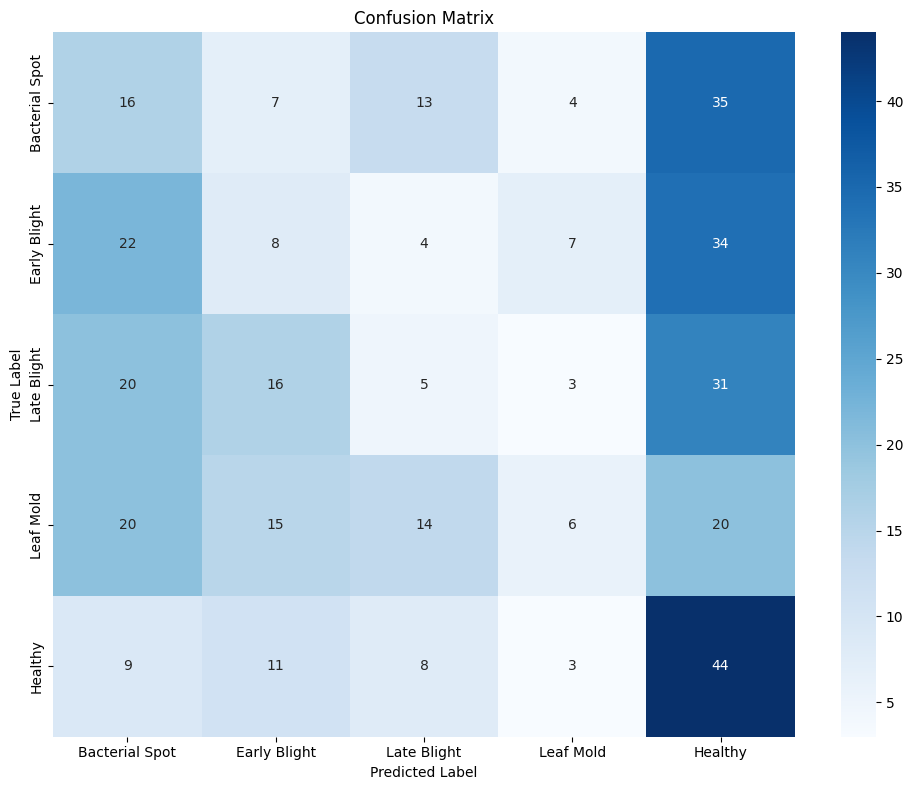

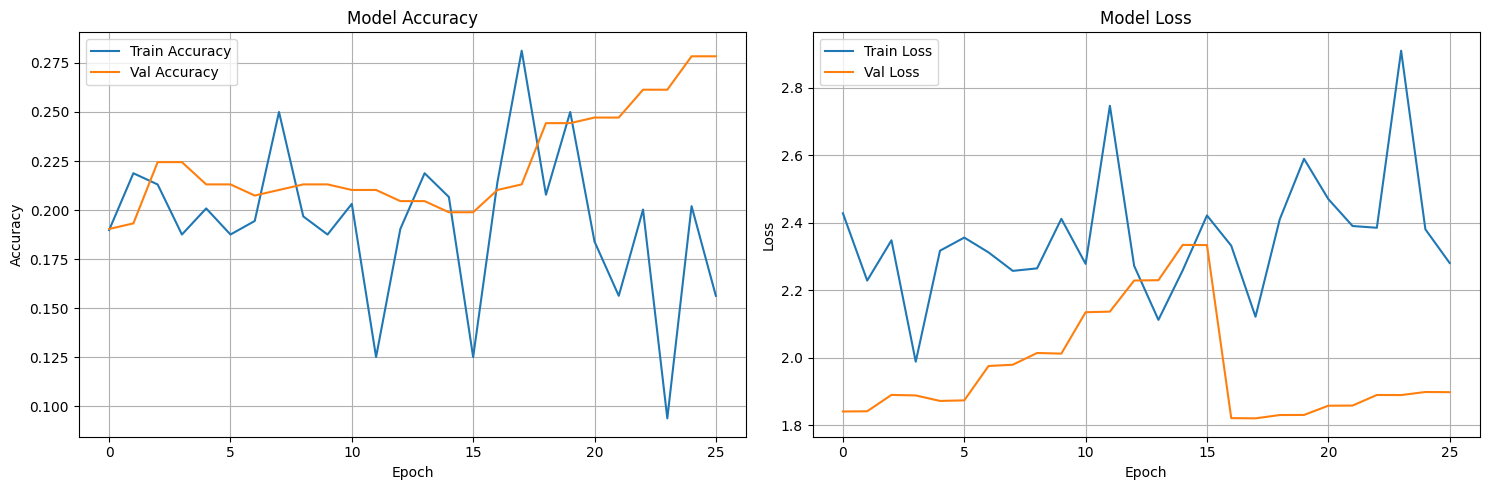


🔍 Sample predictions...


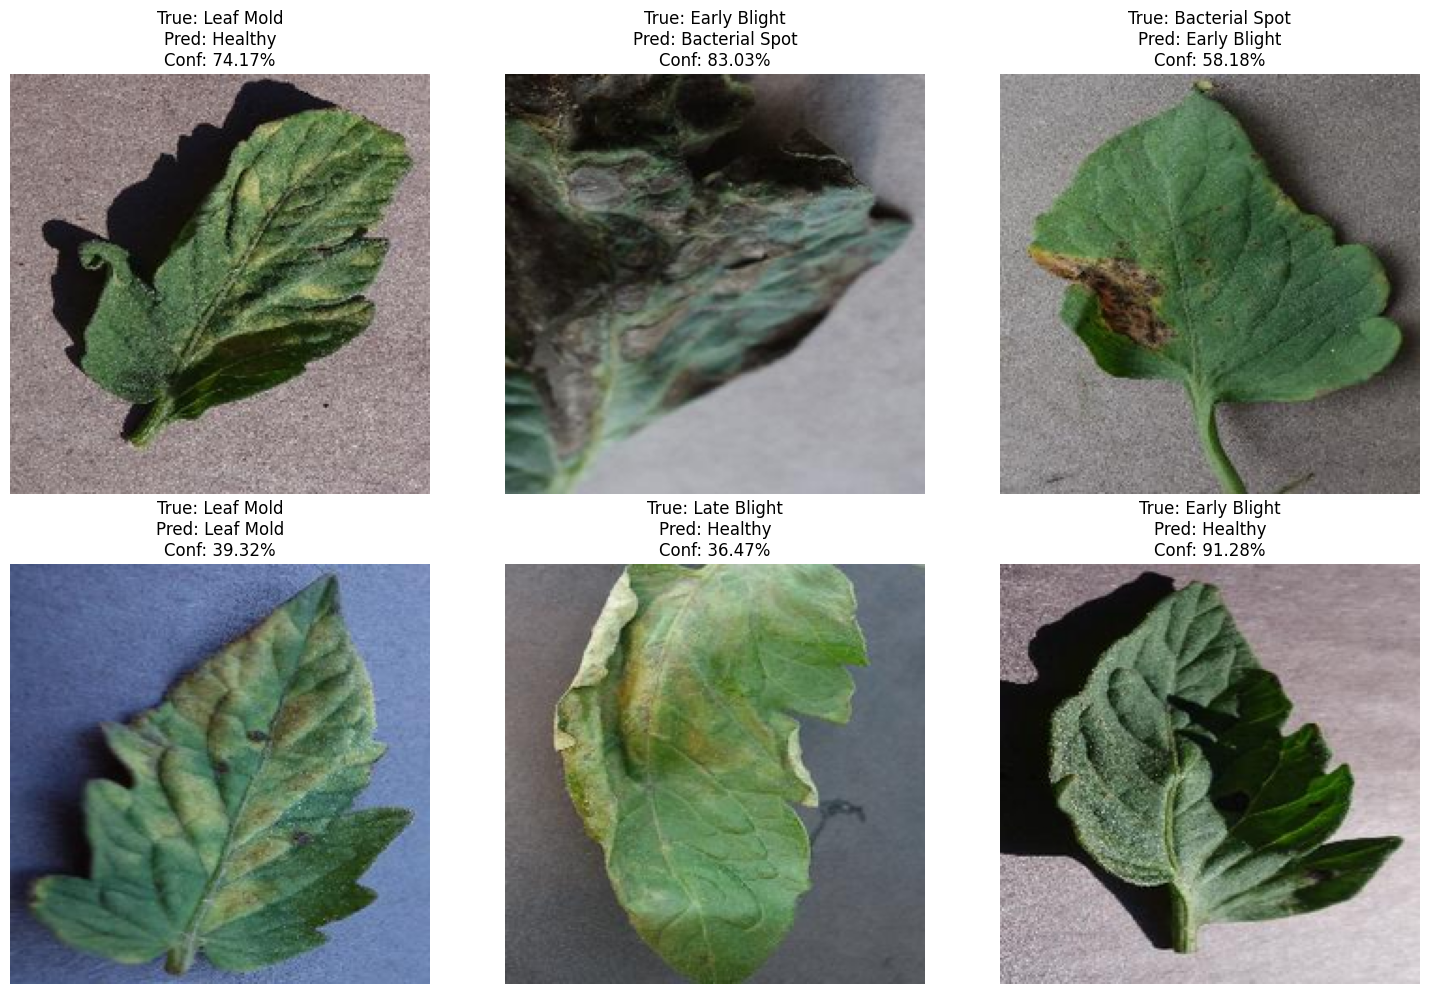

In [ ]:
# Cell 10: Evaluate model
print("\n📊 Evaluating model...")

if os.path.exists('best_model.h5'):
    model = keras.models.load_model('best_model.h5')
    print("✅ Loaded best model")
else:
    print("⚠️ Using last model")

if X_test is not None and len(X_test) > 0:
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_generator, verbose=0)
    print(f"✅ Test Accuracy: {test_acc:.4f}")
    print(f"✅ Test Loss: {test_loss:.4f}")

    # Predictions
    y_pred = model.predict(test_generator, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = y_test

    # Classification report
    from sklearn.metrics import classification_report
    print("\n📋 Classification Report:")
    report = classification_report(y_true, y_pred_classes,
                                  target_names=[SIMPLE_NAMES[c] for c in CLASSES])
    print(report)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[SIMPLE_NAMES[c] for c in CLASSES],
                yticklabels=[SIMPLE_NAMES[c] for c in CLASSES])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=150)
    plt.show()

    # Plot training history
    if history:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        ax1.plot(history['accuracy'], label='Train Accuracy')
        ax1.plot(history['val_accuracy'], label='Val Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)

        ax2.plot(history['loss'], label='Train Loss')
        ax2.plot(history['val_loss'], label='Val Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.savefig('training_history.png', dpi=150)
        plt.show()

        # Show sample predictions
        print("\n🔍 Sample predictions...")
        sample_indices = np.random.choice(len(X_test), min(6, len(X_test)), replace=False)

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        for i, idx in enumerate(sample_indices):
            img = X_test[idx]
            true_label = y_true[idx]

            pred = model.predict(img[np.newaxis, ...], verbose=0)
            pred_class = np.argmax(pred)
            pred_prob = np.max(pred)

            axes[i].imshow(img)
            axes[i].set_title(f"True: {SIMPLE_NAMES[CLASSES[true_label]]}\n"
                             f"Pred: {SIMPLE_NAMES[CLASSES[pred_class]]}\n"
                             f"Conf: {pred_prob:.2%}")
            axes[i].axis('off')

        plt.tight_layout()
        plt.savefig('sample_predictions.png', dpi=150)
        plt.show()
